
### Examining racial discrimination in the US job market

#### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes.

#### Exercise
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Discuss statistical significance.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')
#print(plt.style.available)

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

***
## Explore
Explore the data in the context of: "You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes."

In [3]:
data.shape

(4870, 65)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

In [5]:
data.race.describe()

count     4870
unique       2
top          b
freq      2435
Name: race, dtype: object

In [6]:
n = float(data.race.count())
n_b = float(data.race[data.race=='b'].count())
n_w  = float(data.race[data.race=='w'].count())
print(" sample size: %3.0f \n black sample size: %3.0f (%0.0f%%) \n white sample size: %3.0f (%0.0f%%)" % (n, n_b, n_b/n*100, n_w, n_w/n*100))

 sample size: 4870 
 black sample size: 2435 (50%) 
 white sample size: 2435 (50%)


In [7]:
# break-down by success status and race
tbl = data.groupby(['call', 'race']).size()
tbl

call  race
0     b       2278
      w       2200
1     b        157
      w        235
dtype: int64

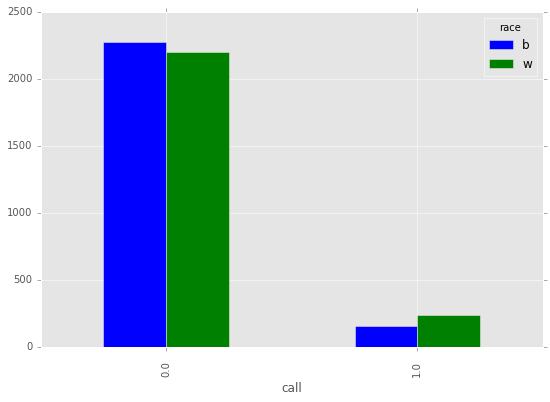

In [8]:
# visual inspection
tbl.unstack().plot(kind='bar');

In [9]:
# all callbacks
callback = sum(data.call)

# number of callbacks for black-sounding names
callback_b = sum(data[data.race=='b'].call)
p_callback_b = callback_b/callback

# number of callbacks for white-sounding names
callback_w = sum(data[data.race=='w'].call)
p_callback_w = callback_w/callback

print('Black-sounding names received %3.0f callbacks (%3.2f%% of %3.0f total callbacks) \
versus white-souding names that received a callback %3.2f%% (%3.0f) of the time.' 
      % (callback_b, p_callback_b*100, callback, p_callback_w*100, callback_w))

Black-sounding names received 157 callbacks (40.05% of 392 total callbacks) versus white-souding names that received a callback 59.95% (235) of the time.


In [10]:
# create a subset of the data with the only the columns of interest.
callbacks = data[['race', 'call']]
callbacks.head()

,race,call
0,w,0
1,w,0
2,b,0
3,b,0
4,w,0


***
## What test is appropriate for this problem? 
This looks to be a problem suited to __inference__ for __binary categorical variables__, given that callbacks are encoded as  yes (1) and no (0) and race has been encoded as 'w' and 'b'. Proportions of successful résumés for black- and -white sounding names will be anlaysed.

### Parameter of Interest
Difference between the proportions of **all** black-sounding names and **all** white-sounding names that receive callbacks in the US.


#### Set Hypothesis
_Null Hypothesis:_ There is no difference between the success rate of applications with black-sounding names (__bsn__) and those with white-sounding names (__wsn__).
_Alternative Hypothesis:_ There is a difference in the success rate.

* $H_o:p_{bsn}-p_{wsn}=0$
* $H_a:p_{bsn}-p_{wsn}\neq0$

In [11]:
# Setting null hypothesis to zero and since I'm not testing a specific direction so this will be a two-sided test
mu = 0

### Point Estimate
Difference between the proportions of __sampled__ black-sounding names and __sampled__ white-sounding names that receive callbacks in the US.

$\hat{p}_{wsn}−\hat{p}_{bsn}$

### Does CLT apply?

Central Limit Theorem (CLT) for proportions (p):
$\hat{p}\>\tilde{}\>N\left(mean=p,\>SE=\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\right)$

Check conditions for CLT to apply
1. indepedence: 
  1. within groups:
    1. random sample/assignment
    2. if sampling without replacement, n < 10% of population 
  2. between groups: the two groups must be independent of each other (non-paired)  
2. sample size/skew:
  1. each sample should have at least 10 sucessess and 10 failures. 
    1. $n_{1}p_{1}\geq10$ and $n_{1}(1-p_{1})\geq10$
    2. $n_{2}p_{2}\geq10$ and $n_{2}(1-p_{2})\geq10$.
  2. If p is unknown then use p-hat.

__Yes, CLT applies__ because __independence__ has been established based on:
1. the sample has been generated by "a randomized field experiment".
2. 2,435 black-sounding names and 2,435 white-sounding names represent much less than 10% of the respective race representation in the US.  
3. The "validity of the names’ 'blackness' or 'whiteness' was confirmed by surveys in public areas in Chicago", so I think it is safe to assume the two groups are independent of each other and that some of hte names don't appear in both groups.

While the __skew/size__ criteria was met with the use of $\hat{p}$ since the population proportion (${p}$) is unknown. Both the black-sounding name and white-sounding name résumés that received callbacks (observed successes) where larger than 10 and the same went for those that did not receive a a callback (observed failures). Please see below.

__So__, we can asumme that the sampling distribution of the difference between two proportions is nearly normal.

In [12]:
p_hat_b = callback_b/n_b
p_hat_w = callback_w/n_w

# observed number of successess
success_b = n_b*p_hat_b
success_w = n_w*p_hat_w

# observed number of failures
failures_b = n_b*(1-p_hat_b)
failures_w = n_w*(1-p_hat_w)

print('Number of black-sounding name successes: %3.0f v. failures: %3.0f' % (success_b, failures_b))
print('Number of white-sounding name successes: %3.0f v. failures: %3.0f' % (success_w, failures_w))


Number of black-sounding name successes: 157 v. failures: 2278
Number of white-sounding name successes: 235 v. failures: 2200


## Confidence Interval
Since no confidence interval has been provided let's go with a confidence of 95% and so an ${\alpha}$ of 0.05.

$(\hat{p_1}−\hat{p_2}) \pm z^{*}SE$

$(\hat{p_1}−\hat{p_2}) \pm z^{*}\left(\sqrt{\frac{\hat{p_1}(1-\hat{p_1})}{n_1} + \frac{\hat{p_2}(1-\hat{p_2})}{n_2}}\right)$


In [13]:
# differnce in proportions between the 2 groups
p_hat = p_hat_b - p_hat_w

# standard error of the two groups
p_hat_SE_b = p_hat_b * (1 - p_hat_b) / n_b 
p_hat_SE_w = p_hat_w * (1 - p_hat_w) / n_w
SE = np.sqrt(p_hat_SE_b + p_hat_SE_w)

#Confidence interval
CI = 0.95
interval = stats.norm.interval(CI, loc=p_hat, scale=SE)

# find the critical values
z = stats.norm.ppf(1 - ((1 - CI) / 2))

# margin of error
ME = z*SE

print "%5s %17s" % ('measurement', 'value')
print 40 * "-"
print('point estimate %17.5f' % p_hat)
print "%5s %24.5f" % ('z-score', z)
print "%5s %12.5f" % ('Standard Error (SE)', SE)
print "%5s %11.5f" % ('Margin of Error (ME)', ME)
print('95%% Confidence Interval %5.3f to %3.3f' % stats.norm.interval(CI, loc=p_hat, scale=SE))

measurement             value
----------------------------------------
point estimate          -0.03203
z-score                  1.95996
Standard Error (SE)      0.00778
Margin of Error (ME)     0.01526
95% Confidence Interval -0.047 to -0.017


***
## Hypothesis test for comparing 2 proportions
As stated earlier the null hypothesis the expectation is that there would be no difference in callbacks received for either black-sounding or whitesounding names, so it what ever the expected success rate of the white-soundings names are, we would expect that the blacks-sounding names would achieve the same success rate. But what would this expected rate be? In order to have a proportion to set the null hypothesis to, we make use of a best guess value calculated with the help of the pooled proportion ($\hat{p}_{pool}$).

$H_o:p_{bsn}=p_{wsn}=\hat{p}_{pool}$

$\hat{p}_{pool}=\frac{total\>successes}{total\>n}$

In [14]:
p_hat_pool = (success_b+success_w) / (n_b+n_w)
print("p̂-pool as estimate of common proportion for the 2 groups = %3.5f" % p_hat_pool)

p̂-pool as estimate of common proportion for the 2 groups = 0.08049


Need to check that the pooled proportion ($\hat{p}_{pool}$) still has at least 10 sucessess and 10 failures.
* $n_{1}\hat{p}_{pool}\geq10$ and $n_{1}(1-\hat{p}_{pool})\geq10$
* $n_{2}\hat{p}_{pool}\geq10$ and $n_{2}(1-\hat{p}_{pool})\geq10$

In [15]:
# observed number of successess
success_b_pool = n_b*p_hat_pool
success_w_pool = n_w*p_hat_pool

# observed number of failures
failures_b_pool = n_b*(1-p_hat_pool)
failures_w_pool = n_w*(1-p_hat_pool)

print('Number of black-sounding name successes: %3.0f v. failures: %3.0f' % (success_b_pool, failures_b_pool))
print('Number of white-sounding name successes: %3.0f v. failures: %3.0f' % (success_w_pool, failures_w_pool))

Number of black-sounding name successes: 196 v. failures: 2239
Number of white-sounding name successes: 196 v. failures: 2239


The proportions of successes and failures are the exactly the same because the only difference in the calculation is the number of records for each and since the data is split 50/50 between black-sounding and white-sounding names, their expected porportions of success and failures are the same.

And since the the successes and the failures for both groups are greater than 10, and all of the previous assumtion on independence reamin in place, we can continue on with the assumption that the sampling distribution of the difference between two proportions is nearly normal.

Moving on to the standard error (SE).

The expected standard error for a 2 proportion hypothesis can be calculated as:

$SE=\sqrt{\frac{\hat{p}_{pool}(1-\hat{p}_{pool})}{n_1} + \frac{\hat{p}_{pool}(1-\hat{p}_{pool})}{n_2}}$

In [16]:
#
SE_b = p_hat_pool*(1 - p_hat_pool) / n_b 
SE_w = p_hat_pool*(1 - p_hat_pool) / n_w
SE = np.sqrt(SE_w + SE_b)
z = (p_hat-mu) / SE
ME = z*SE
p = (1-stats.norm.cdf(np.abs(z)))*2

print "%5s %17s" % ('measurement', 'value')
print 40 * "-"
print('point estimate %17.5f' % p_hat)
print('null hypothesis %16.5f' % mu)
print "%5s %24.5f" % ('z-score', z)
print "%5s %12.5f" % ('Standard Error (SE)', SE)
print "%5s %11.5f" % ('Margin of Error (ME)', ME)
print "%5s %24.5f" % ('p-value', p)

measurement             value
----------------------------------------
point estimate          -0.03203
null hypothesis          0.00000
z-score                 -4.10841
Standard Error (SE)      0.00780
Margin of Error (ME)    -0.03203
p-value                  0.00004


## Discuss statistical significance

Given that the p-value is significantly smaller than the required >0.05 threshold set for a confidence interval of 95%, so the null hypothesis is rejected. Holding all things else equal, having a black-sounding name seems to have disproportionate impact on whether you receive a callback or not. 